In [1]:
!pip3 install shap


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
from shapley_values.rational_shap import RationalExplainer
from shapley_values.causal_shap import ShapleyValuesType, Explainer
from shapley_values.utils import get_baseline
import numpy as np
from sklearn.linear_model import LinearRegression
import shap
from functools import partial

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('dataset/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [4]:
np.random.seed(0)

X_df = df.drop(columns=['price', 'street', 'city', 'statezip', 'country', 'date', 'view', 'sqft_above', "waterfront", "condition", "yr_renovated", "sqft_lot", "yr_built"])
y = df[['price']]

model = LinearRegression()
model.fit(X_df.to_numpy(), y.to_numpy()[:, 0])

LinearRegression()

In [5]:
sample = {
    "bedrooms": 3,
    "bathrooms": 2,
    "sqft_living": 2700,
    "floors": 2,
    "sqft_basement": 450
}   

In [6]:
print(f"Predicted price of house {int(model.predict(np.array([list(sample.values())]))[0])}$")

Predicted price of house 735073$


### Computing Marginal Shapley Values

In [7]:
X = X_df.to_numpy()[:2000]
feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_basement']

In [ ]:
explainer = Explainer(X = X, model = model, is_classification=False, rounding_precision = 0, feature_names=feature_names)
phis = explainer.compute_shapley_values(list(sample.values()), type = ShapleyValuesType.MARGINAL)

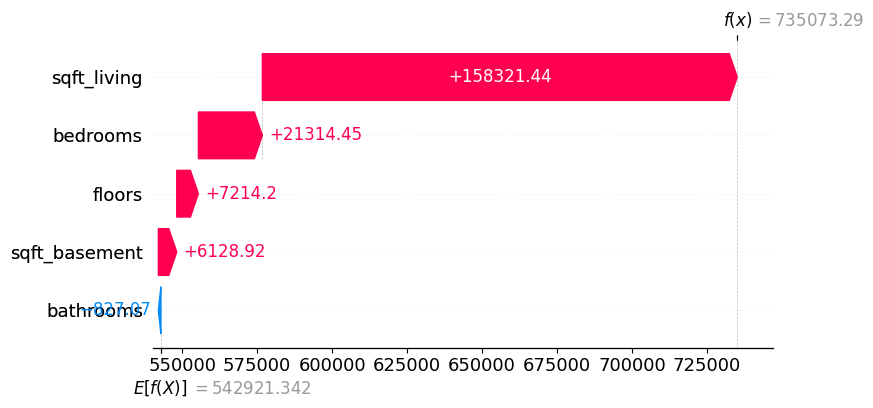

In [60]:
explanation = shap.Explanation(values=np.array([phi[0] for phi in phis]),
                                feature_names=list(sample.keys()),
                                base_values=get_baseline(np.round(X, 0), model),
                                output_names=['Prediction'])

shap.plots.waterfall(explanation)

## Rational Marginal Shapley Values - Person A

Compute relevant subspaces

In [8]:
X_A = X_df[(X_df['floors'] == 2) & (X_df['bedrooms'] == 3)]
X_B = X_df[(X_df['sqft_basement'] > 400)]

Create reward function

In [9]:
def scale_value(value, threshold):
    if value > threshold:
        return 1
    elif value < 0:
        return 0
    else:
        return value / threshold

In [10]:
utility_dataframe_personA = pd.DataFrame([["Decrease sqft_living.", partial(scale_value, threshold=25000), 2, 1],
                   ["Decrease number of bedroom", partial(scale_value, threshold=25000), 0, -2],
                   ["Decrease basement", partial(scale_value, threshold=25000), 4, 2]], 
                  columns=["explanation", "action", "feature_index", "weight"])


In [11]:
def compute_reward_function(phis: list [float], utility_dataframe: pd.DataFrame) -> float:
    """ 
    Computes reward function

    Args:
        phis (list[float]): A list of Shapley value (evidence)
        utility_dataframe (pd.DataFrame)
    Returns:
        reward (float): Reward user might get for this phis.

    Define function that somehow accepts utility function.
    """

    def utility_function(parameter_index, parameter_attribution):
        row = utility_dataframe[utility_dataframe_personA['feature_index'] == parameter_index]
        
        if not row.empty:
            row = row.iloc[0]
            action_function = row["action"]
            weight = row["weight"]
            return action_function(parameter_attribution) * weight
        else:
            return 0

    reward = 0

    for index, feature_attribution in enumerate(phis):
        reward += utility_function(index, feature_attribution)
    
    
    return reward / len(phis)
        
    

In [12]:
compute_reward_function_personA = partial(compute_reward_function, utility_dataframe = utility_dataframe_personA)

In [ ]:
explainer = RationalExplainer(subspaces = [X_A.to_numpy(), X_B.to_numpy()], model = model, is_classification=False, rounding_precision = 0, feature_names=feature_names)
phis_reward_map_A = explainer.compute_rational_shapley_values(list(sample.values()), compute_reward_function_personA, type = ShapleyValuesType.MARGINAL)

In [14]:
phis_reward_map_A

{0.4353306306876027: [0.0,
  -2270.458404941271,
  136008.00288705408,
  0.0,
  14708.164417975164],
 -0.2: [43018.88884355609,
  -4332.058859101793,
  38385.060194058075,
  10254.067596216666,
  -20918.27029915819]}

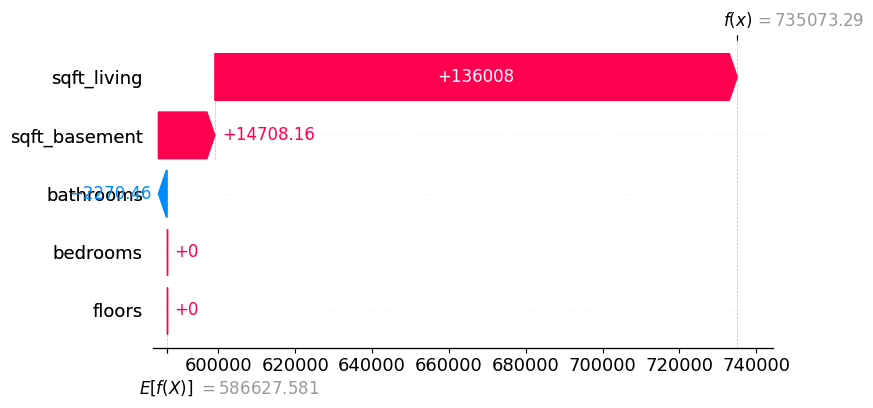

In [15]:
explanation = shap.Explanation(values=np.array(phis_reward_map_A[max(phis_reward_map_A)]),
                                feature_names=list(sample.keys()),
                                base_values=get_baseline(np.round(X_A.to_numpy(), 0), model),
                                output_names=['Prediction'])

shap.plots.waterfall(explanation)

## Rational Marginal Shapley values - Person B

Create reward function

In [16]:
utility_dataframe_personB = pd.DataFrame([["Decrease sqft_living.", partial(scale_value, threshold=25000), 2, 1],
                   ["Decrease number of bedroom", partial(scale_value, threshold=25000), 0, 2],
                   ["Decrease basement", partial(scale_value, threshold=25000), 4, -2]], 
                  columns=["explanation", "action", "feature_index", "weight"])


In [17]:
compute_reward_function_personB = partial(compute_reward_function, utility_dataframe = utility_dataframe_personB)

In [ ]:
explainer = RationalExplainer(subspaces = [X_A.to_numpy(), X_B.to_numpy()], model = model, is_classification=False, rounding_precision = 0, feature_names=feature_names)
phis_reward_map_B = explainer.compute_rational_shapley_values(list(sample.values()), compute_reward_function_personB, type = ShapleyValuesType.MARGINAL)

In [21]:
phis_reward_map_B

{-0.03533063068760249: [0.0,
  -2270.458404941271,
  136008.002887054,
  0.0,
  14708.164417975157],
 0.6: [43018.88884355608,
  -4332.058859101793,
  38385.06019405807,
  10254.06759621667,
  -20918.270299158194]}

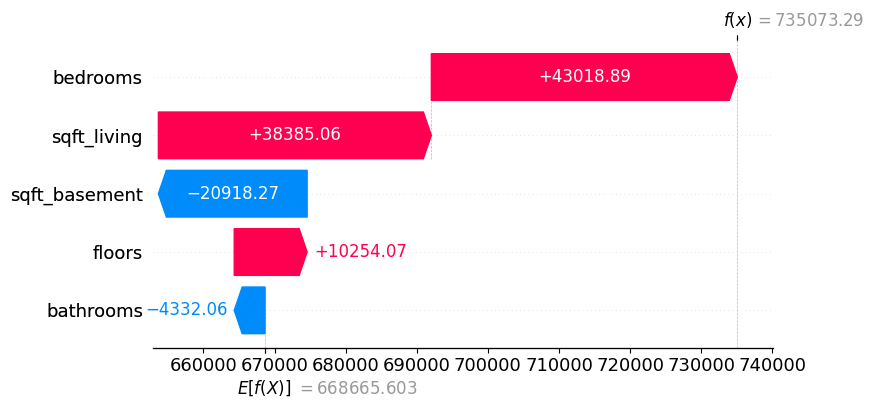

In [66]:
explanation = shap.Explanation(values=phis_reward_map_B[max(phis_reward_map_B)],
                                feature_names=list(sample.keys()),
                                base_values=get_baseline(np.round(X_B.to_numpy(), 0), model),
                                output_names=['Prediction'])

shap.plots.waterfall(explanation)